In [0]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.metrics import mean_squared_error
from keras.layers import Dense,LSTM,GRU,RepeatVector,TimeDistributed,Conv1D,Conv2D,Dropout,BatchNormalization,Reshape, Flatten, MaxPooling1D, Bidirectional
from keras.layers.merge import concatenate
from keras import optimizers
from keras.models import Sequential,Model
from keras.engine.input_layer import Input
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from keras.callbacks import History, ModelCheckpoint
import matplotlib.pyplot as plt
from keras import regularizers
from keras.utils import plot_model
from pathlib import Path
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
def find_autocorelation_coeff(train,n_input):
  train_data_reshaped=train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
  original,lagged = list(),list()
  start=0

  for i in range(len(train_data_reshaped)):
    end= start + n_input
    if end>=len(train_data_reshaped):
      break
    original.append(train_data_reshaped[start,0])
    lagged.append(train_data_reshaped[end,0])
    start= start+1
  
  original_array= np.array(original)
  lagged_array= np.array(lagged)

  original_array = original_array.reshape(original_array.shape[0],1)
  lagged_array = lagged_array.reshape(lagged_array.shape[0],1)
  
  single_array = np.concatenate((original_array,lagged_array), axis=1)
  return spearmanr(single_array)[0]

In [0]:
def read_data(filepath):
  data=pd.read_csv(filepath,index_col='No',header=0,parse_dates=True)#removed index_col = 'no'
  #data.drop(['station','wd'],axis=1,inplace=True)
  column_til=["PM2.5","year","month","day","hour","PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","WSPM"]#FOR BEIJING
  #column_til=["PM2.5","hour","PM10","NH3","Benzene"] #FOR DELHI
  data=data.reindex(columns=column_til)
  return data

In [0]:
#Data Preprocessing - need to move to seperate file
def fill_miss(values,data):
  one_day=24
  for i in range(values.shape[0]):
    for j in range(values.shape[1]):
      if np.isnan(values[i,j]):
        data.fillna(method='ffill',inplace=True)
  return data

In [0]:
def label_encoder(data):
  encoder = LabelEncoder()
  data.iloc[:,15]= encoder.fit_transform(np.array(data.iloc[:,15]))
  return data

In [0]:
#data.iloc[:,15]
#data.drop(['wd'],axis=1,inplace=True)

In [0]:
def feature_selection(train_normalized,test_normalized):
  X_train,Y_train= train_normalized[0:365*24*3,1:],train_normalized[0:365*24*3,0]
  X_test,Y_test = test_normalized[0:365*24*1,1:], test_normalized[0:365*24*1,0]
  reg = xgb.XGBRegressor(n_estimators=1000)
  reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) 
  xgb.plot_importance(reg, height=0.9)

In [0]:
#Normalize the dataset, return normalized_data, inverse_normalized data and scaler
def normalize_data(data):
  data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data)
  print(scaler.data_max_)
  print(scaler.data_min_)
  data_normalized=scaler.transform(data)
  len(data_normalized)
  data_inv= scaler.inverse_transform(data_normalized)
  #print(data.iloc[365*24*3,0])
  return data_normalized,data_inv,scaler


In [0]:
#Have not changed the split by 24 here
def split(data_normalized):  #CORRECT
    train,test=data_normalized[0:365*24*3],data_normalized[365*24*3:365*24*4]
    train=np.split(train,len(train)/24)
    test=np.split(test,len(test)/24)
    return np.array(train),np.array(test)

In [0]:
def eval_mape(actual,predicted):
  mape=0
  for i in range(len(actual)):
    mape = mape + (abs(actual[i]-predicted[i])/actual[i])
  mape = mape/len(actual)
  mape = mape*100
  return mape


In [0]:
def new_eval_forecast(actual,predicted):
  true_rmse=0
  true_rmse=sqrt(mean_squared_error(actual[:],predicted[:]))
  return true_rmse

In [0]:
#NO CHANGE
def eval_forecast(actual,predicted):
    scores=list()
    for i in range(actual.shape[1]):
        scores.append(sqrt(mean_squared_error(actual[:,i],predicted[:,i])))
    return scores

In [0]:
#NO CHANGE
def to_supervised(train,n_input,n_out):
    train_data_reshaped=train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    x,y=list(),list()
    start=0
    for i in range(len(train_data_reshaped)):
        in_end=start+n_input
        out_end=in_end+n_out
        if out_end>len(train_data_reshaped):
            break
        x.append(train_data_reshaped[start:in_end,0:])
        y.append(train_data_reshaped[in_end:out_end,0])
        start=start+1
    return np.array(x),np.array(y)

In [0]:
#ENCODER - DECODER MODEL for multi-step predictions.
#Not being used right now
def build_model_for_multistep(train,n_input):
    global history
    train_x,train_y=to_supervised(train,n_input,2)
    print("labels created")
    print(train_x.shape[0])
    n_timesteps,n_features,n_outputs=train_x.shape[1],train_x.shape[2],train_y.shape[1]
    train_y=train_y.reshape((train_y.shape[0],train_y.shape[1],1))
    print(train_x.shape)
    print(train_y.shape)
    model=Sequential()
    model.add(LSTM(20,activation='relu',input_shape=(n_timesteps,n_features),return_sequences=False))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(LSTM(30,activation='relu'))
    model.add(RepeatVector(n_outputs)) # repeats the input to the layer n_output no of times, so for each of the 24 timesteps in a sample, the 200-element hidden state vector(of the last timestep in that sample) would be repeated. output shape - 24 * 200
    model.add(LSTM(20,activation='relu',return_sequences=True))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(LSTM(30,activation='relu',return_sequences=True))
    #model.add(LSTM(15,activation='relu',return_sequences=True))
    #model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(100,activation='relu'))) #Time Distributed used to apply the same Dense layer to each of the timesteps in a sequence(sample). Thus a 24*200 sample would be coverted to a 24*100 sample. Subsequently to 24*1
    model.add(TimeDistributed(Dense(1)))#Basically by using "time-distributed" func, we are ensuring that the dense layer works on EACH of the timesteps in the sample. 
    model.compile(loss='mse',optimizer='adam')
    print("loss set for model")
    model.summary()
    history=model.fit(train_x,train_y,epochs=25,batch_size=15,verbose=1)
    return model 

In [0]:
def CNN_LSTM1(n_timesteps,n_features):
    new_model = Sequential()
    new_model.add(Conv1D(input_shape=(n_timesteps, n_features), strides=1, kernel_size=2, filters=64))
    new_model.add(Conv1D(strides=1, kernel_size=2, filters=64))
    new_model.add(LSTM(40,activation='relu', return_sequences=True)) # 1 *50
    new_model.add(LSTM(40,activation='relu'))
    
    #new_model.add(MaxPooling1D(pool_size=2))
    #new_model.add(Bidirectional(GRU(10, activation='relu', return_sequences='True')))
    #new_model.add(Bidirectional(GRU(10, activation='relu')))
    new_model.add(Dense(20, activation='relu'))
    new_model.add(Dense(1,activation='relu'))

    new_model.compile(optimizer='adam', loss='mse')
    new_model.summary()

    return new_model


In [0]:
#Pure LSTM based model for single step prediction
def pure_LSTM(n_timesteps,n_features):
    model=Sequential()
    model.add(LSTM(20,activation='relu',input_shape=(n_timesteps,n_features),return_sequences=True))# 4 * 50
    model.add(LSTM(20,activation='relu', return_sequences=True)) # 1 *50
    model.add(LSTM(20,activation='relu',return_sequences=True)) # 1*50
    model.add(LSTM(20,activation='relu')) # 1 *50
    
    model.add(Dense(100,activation='relu'))
    model.add(Dense(1, activation= 'relu'))
    model.compile(loss='mse',optimizer='adam')
    model.summary()
    return model
  

In [0]:
def pure_GRU(n_timesteps,n_features):
    model=Sequential()
    model.add(GRU(20,activation='relu',input_shape=(n_timesteps,n_features),return_sequences=True))# 4 * 50
    model.add(GRU(20,activation='relu', return_sequences=True)) # 1 *50
    model.add(GRU(20,activation='relu',return_sequences=True)) # 1*50
    model.add(GRU(20,activation='relu')) # 1 *50
    
    model.add(Dense(100,activation='relu'))
    model.add(Dense(1, activation= 'relu'))
    model.compile(loss='mse',optimizer='adam')
    model.summary()
    return model
    

In [0]:
def Bidirectional_GRU(n_timesteps,n_features):
  model=Sequential()
  model.add(Bidirectional(GRU(20,activation='relu', return_sequences=True), input_shape=(n_timesteps,n_features)))
  model.add(Bidirectional(GRU(20,activation='relu', return_sequences=True)))
  model.add(Bidirectional(GRU(20,activation='relu', return_sequences=True)))
  model.add(Bidirectional(GRU(20,activation='relu', return_sequences=True)))
  #model.add(Bidirectional(GRU(10,activation='relu', return_sequences=True)))
  #model.add(Bidirectional(GRU(10,activation='relu', return_sequences=True)))
  model.add(Bidirectional(GRU(20,activation='relu')))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='mse',optimizer='adam')
  model.summary()
  return model


In [0]:
def reshape_samples_for_Conv1D(train_x):
    X1 = train_x[:,:,0].reshape(train_x.shape[0],train_x.shape[1],1)
    X2 = train_x[:,:,1].reshape(train_x.shape[0],train_x.shape[1],1)
    X3 = train_x[:,:,2].reshape(train_x.shape[0],train_x.shape[1],1)
    X4 = train_x[:,:,3].reshape(train_x.shape[0],train_x.shape[1],1)
    X5 = train_x[:,:,4].reshape(train_x.shape[0],train_x.shape[1],1)
    X6 = train_x[:,:,5].reshape(train_x.shape[0],train_x.shape[1],1)
    X7 = train_x[:,:,6].reshape(train_x.shape[0],train_x.shape[1],1)
    X8 = train_x[:,:,7].reshape(train_x.shape[0],train_x.shape[1],1)
    X9 = train_x[:,:,8].reshape(train_x.shape[0],train_x.shape[1],1)
    X10 = train_x[:,:,9].reshape(train_x.shape[0],train_x.shape[1],1)
    X11 = train_x[:,:,10].reshape(train_x.shape[0],train_x.shape[1],1)
    X12 = train_x[:,:,11].reshape(train_x.shape[0],train_x.shape[1],1)
    X13 = train_x[:,:,12].reshape(train_x.shape[0],train_x.shape[1],1)
    X14 = train_x[:,:,13].reshape(train_x.shape[0],train_x.shape[1],1)
    X15 = train_x[:,:,14].reshape(train_x.shape[0],train_x.shape[1],1)

    return X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15


In [0]:
def CNN(n_timesteps):
    #14 submodels, a CNN is trained for each feature vector
    visible1 = Input(shape=(n_timesteps, 1))
    cnn1 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible1)
    cnn1 = MaxPooling1D(pool_size=3)(cnn1)
    cnn1 = Flatten()(cnn1)

    visible2 = Input(shape=(n_timesteps, 1))
    cnn2 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible2)
    cnn2 = MaxPooling1D(pool_size=3)(cnn2)
    cnn2 = Flatten()(cnn2)

    visible3 = Input(shape=(n_timesteps, 1))
    cnn3 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible3)
    cnn3 = MaxPooling1D(pool_size=3)(cnn3)
    cnn3 = Flatten()(cnn3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    cnn4 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible4)
    cnn4 = MaxPooling1D(pool_size=3)(cnn4)
    cnn4 = Flatten()(cnn4)

    visible5 = Input(shape=(n_timesteps, 1))
    cnn5 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible5)
    cnn5 = MaxPooling1D(pool_size=3)(cnn5)
    cnn5 = Flatten()(cnn5)

    visible6 = Input(shape=(n_timesteps, 1))
    cnn6 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible6)
    cnn6 = MaxPooling1D(pool_size=3)(cnn6)
    cnn6 = Flatten()(cnn6)

    visible7 = Input(shape=(n_timesteps, 1))
    cnn7 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible7)
    cnn7 = MaxPooling1D(pool_size=3)(cnn7)
    cnn7 = Flatten()(cnn7)

    visible8 = Input(shape=(n_timesteps, 1))
    cnn8 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible8)
    cnn8 = MaxPooling1D(pool_size=3)(cnn8)
    cnn8 = Flatten()(cnn8)

    visible9 = Input(shape=(n_timesteps, 1))
    cnn9 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible9)
    cnn9 = MaxPooling1D(pool_size=3)(cnn9)
    cnn9 = Flatten()(cnn9)

    visible10 = Input(shape=(n_timesteps, 1))
    cnn10 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible10)
    cnn10 = MaxPooling1D(pool_size=3)(cnn10)
    cnn10 = Flatten()(cnn10)

    visible11 = Input(shape=(n_timesteps, 1))
    cnn11 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible11)
    cnn11 = MaxPooling1D(pool_size=3)(cnn11)
    cnn11 = Flatten()(cnn11)

    visible12 = Input(shape=(n_timesteps, 1))
    cnn12 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible12)
    cnn12 = MaxPooling1D(pool_size=3)(cnn12)
    cnn12 = Flatten()(cnn12)

    visible13 = Input(shape=(n_timesteps, 1))
    cnn13 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible13)
    cnn13 = MaxPooling1D(pool_size=3)(cnn13)
    cnn13 = Flatten()(cnn13)

    visible14 = Input(shape=(n_timesteps, 1))
    cnn14 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible14)
    cnn14 = MaxPooling1D(pool_size=3)(cnn14)
    cnn14 = Flatten()(cnn14)

    visible15 = Input(shape=(n_timesteps, 1))
    cnn15 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible15)
    cnn15 = MaxPooling1D(pool_size=3)(cnn15)
    cnn15 = Flatten()(cnn15)

    merged = concatenate([cnn1,cnn2,cnn3,cnn4,cnn5,cnn6,cnn7,cnn8,cnn9,cnn10,cnn11,cnn12,cnn13,cnn14,cnn15]) #none*(64*14)
    merged = Dense(25)(merged)
    output = Dense(1)(merged)

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')
    model.summary()
    return model

In [0]:
def CNN_LSTM(n_timesteps):
    #15 submodels, a CNN is trained for each feature vector
    visible1 = Input(shape=(n_timesteps, 1))
    cnn1 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible1)
    #cnn1 = MaxPooling1D(pool_size=2)(cnn1)
    #cnn1 = Flatten(cnn1)

    visible2 = Input(shape=(n_timesteps, 1))
    cnn2 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible2)
    #cnn2 = MaxPooling1D(pool_size=2)(cnn2)
    #cnn2 = Flatten(cnn2)

    visible3 = Input(shape=(n_timesteps, 1))
    cnn3 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible3)
    #cnn3 = MaxPooling1D(pool_size=2)(cnn3)
    #cnn3 = Flatten(cnn3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    cnn4 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible4)
    #cnn4 = MaxPooling1D(pool_size=2)(cnn4)
    #cnn4 = Flatten(cnn4)

    visible5 = Input(shape=(n_timesteps, 1))
    cnn5 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible5)
    #cnn5 = MaxPooling1D(pool_size=2)(cnn5)
    #cnn5 = Flatten(cnn5)

    visible6 = Input(shape=(n_timesteps, 1))
    cnn6 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible6)
    #cnn6 = MaxPooling1D(pool_size=2)(cnn6)
    #cnn6 = Flatten(cnn1)

    
    visible7 = Input(shape=(n_timesteps, 1))
    cnn7 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible7)
    #cnn7 = MaxPooling1D(pool_size=2)(cnn7)
    #cnn7 = Flatten(cnn7)

    
    visible8 = Input(shape=(n_timesteps, 1))
    cnn8 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible8)
    #cnn8 = MaxPooling1D(pool_size=2)(cnn8)
    #cnn8 = Flatten(cnn8)

    visible9 = Input(shape=(n_timesteps, 1))
    cnn9 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible9)
    #cnn9 = MaxPooling1D(pool_size=2)(cnn9)
    #cnn9 = Flatten(cnn9)

    visible10 = Input(shape=(n_timesteps, 1))
    cnn10 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible10)
    #cnn10 = MaxPooling1D(pool_size=2)(cnn10)
    #cnn10 = Flatten(cnn1)

    visible11 = Input(shape=(n_timesteps, 1))
    cnn11 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible11)
    #cnn11 = MaxPooling1D(pool_size=2)(cnn11)
    #cnn11 = Flatten(cnn11)

    visible12 = Input(shape=(n_timesteps, 1))
    cnn12 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible12)
    #cnn12 = MaxPooling1D(pool_size=2)(cnn12)
    #cnn12 = Flatten(cnn12)

    visible13 = Input(shape=(n_timesteps, 1))
    cnn13 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible13)
    #cnn13 = MaxPooling1D(pool_size=2)(cnn13)
    #cnn13 = Flatten(cnn13)

    visible14 = Input(shape=(n_timesteps, 1))
    cnn14 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible14)
    #cnn14 = MaxPooling1D(pool_size=2)(cnn14)
    #cnn14 = Flatten(cnn14)

    visible15 = Input(shape=(n_timesteps, 1))
    cnn15 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible15)
    #cnn15 = MaxPooling1D(pool_size=2)(cnn15)
    #cnn15 = Flatten(cnn15)

    
    

    merged = concatenate([cnn1,cnn2,cnn3,cnn4,cnn5,cnn6,cnn7,cnn8,cnn9,cnn10,cnn11,cnn12,cnn13,cnn14,cnn15]) # 3* (64*13)
    merged = LSTM(50,activation='relu',return_sequences=True)(merged) # 3*50 # initially filters were 64, now 1
    merged = LSTM(50,activation='relu',return_sequences=True)(merged)# 3*50
    merged=  LSTM(50,activation='relu')(merged) # 1*50
    merged = Dense(25)(merged)
    output = Dense(1)(merged) # 1*1

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')
    model.summary()
    return model

In [0]:
def CNN_GRU(n_timesteps):
    #14 submodels, a CNN is trained for each feature vector
    visible1 = Input(shape=(n_timesteps, 1))
    cnn1 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible1)
    #cnn1 = MaxPooling1D(pool_size=2)(cnn1)
    #cnn1 = Flatten(cnn1)

    visible2 = Input(shape=(n_timesteps, 1))
    cnn2 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible2)
    #cnn2 = MaxPooling1D(pool_size=2)(cnn2)
    #cnn2 = Flatten(cnn2)

    visible3 = Input(shape=(n_timesteps, 1))
    cnn3 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible3)
    #cnn3 = MaxPooling1D(pool_size=2)(cnn3)
    #cnn3 = Flatten(cnn3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    cnn4 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible4)
    #cnn4 = MaxPooling1D(pool_size=2)(cnn4)
    #cnn4 = Flatten(cnn4)

    visible5 = Input(shape=(n_timesteps, 1))
    cnn5 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible5)
    #cnn5 = MaxPooling1D(pool_size=2)(cnn5)
    #cnn5 = Flatten(cnn5)

    visible6 = Input(shape=(n_timesteps, 1))
    cnn6 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible6)
    #cnn6 = MaxPooling1D(pool_size=2)(cnn6)
    #cnn6 = Flatten(cnn1)

    visible7 = Input(shape=(n_timesteps, 1))
    cnn7 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible7)
    #cnn7 = MaxPooling1D(pool_size=2)(cnn7)
    #cnn7 = Flatten(cnn7)

    visible8 = Input(shape=(n_timesteps, 1))
    cnn8 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible8)
    #cnn8 = MaxPooling1D(pool_size=2)(cnn8)
    #cnn8 = Flatten(cnn8)

    visible9 = Input(shape=(n_timesteps, 1))
    cnn9 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible9)
    #cnn9 = MaxPooling1D(pool_size=2)(cnn9)
    #cnn9 = Flatten(cnn9)

    visible10 = Input(shape=(n_timesteps, 1))
    cnn10 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible10)
    #cnn10 = MaxPooling1D(pool_size=2)(cnn10)
    #cnn10 = Flatten(cnn1)

    visible11 = Input(shape=(n_timesteps, 1))
    cnn11 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible11)
    #cnn11 = MaxPooling1D(pool_size=2)(cnn11)
    #cnn11 = Flatten(cnn11)

    visible12 = Input(shape=(n_timesteps, 1))
    cnn12 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible12)
    #cnn12 = MaxPooling1D(pool_size=2)(cnn12)
    #cnn12 = Flatten(cnn12)

    visible13 = Input(shape=(n_timesteps, 1))
    cnn13 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible13)
    #cnn13 = MaxPooling1D(pool_size=2)(cnn13)
    #cnn13 = Flatten(cnn13)

    visible14 = Input(shape=(n_timesteps, 1))
    cnn14 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible14)
    #cnn14 = MaxPooling1D(pool_size=2)(cnn14)
    #cnn14 = Flatten(cnn14)


    visible15 = Input(shape=(n_timesteps, 1))
    cnn15 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible15)
    #cnn15 = MaxPooling1D(pool_size=2)(cnn15)
    #cnn15 = Flatten(cnn15)

    merged = concatenate([cnn1,cnn2,cnn3,cnn4,cnn5,cnn6,cnn7,cnn8,cnn9,cnn10,cnn11,cnn12,cnn13,cnn14,cnn15]) # 3* (64*13)
    merged = GRU(50,activation='relu',return_sequences=True)(merged) # 3*50 # initially filters were 64, now 1
    merged = GRU(50,activation='relu',return_sequences=True)(merged)# 3*50
    merged=  GRU(50,activation='relu')(merged) # 1*50
    merged = Dense(25)(merged)
    output = Dense(1)(merged) # 1*1

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')

    model.summary()
    return model


In [0]:
def multiheaded_with_LSTM(n_timesteps):
    #14 submodels, a CNN is trained for each feature vector

    visible1 = Input(shape=(n_timesteps, 1))
    cnn1 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible1)
    lstm1= LSTM(20,activation='relu',return_sequences=True)(cnn1)
    lstm1 = LSTM(20,activation='relu')(lstm1)
    

    visible2 = Input(shape=(n_timesteps, 1))
    cnn2 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible2)
    lstm2= LSTM(20,activation='relu',return_sequences=True)(cnn2)
    lstm2 = LSTM(20,activation='relu')(lstm2)

    visible3 = Input(shape=(n_timesteps, 1))
    cnn3 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible3)
    lstm3= LSTM(20,activation='relu',return_sequences=True)(cnn3)
    lstm3 = LSTM(20,activation='relu')(lstm3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    cnn4 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible4)
    lstm4= LSTM(20,activation='relu',return_sequences=True)(cnn4)
    lstm4 = LSTM(20,activation='relu')(lstm4)

    visible5 = Input(shape=(n_timesteps, 1))
    cnn5 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible5)
    lstm5= LSTM(20,activation='relu',return_sequences=True)(cnn5)
    lstm5 = LSTM(20,activation='relu')(lstm5)

    visible6 = Input(shape=(n_timesteps, 1))
    cnn6 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible6)
    lstm6= LSTM(20,activation='relu',return_sequences=True)(cnn6)
    lstm6 = LSTM(20,activation='relu')(lstm6)

    visible7 = Input(shape=(n_timesteps, 1))
    cnn7 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible7)
    lstm7= LSTM(20,activation='relu',return_sequences=True)(cnn7)
    lstm7 = LSTM(20,activation='relu')(lstm7)

    visible8 = Input(shape=(n_timesteps, 1))
    cnn8 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible8)
    lstm8= LSTM(20,activation='relu',return_sequences=True)(cnn8)
    lstm8 = LSTM(20,activation='relu')(lstm8)

    visible9 = Input(shape=(n_timesteps, 1))
    cnn9 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible9)
    lstm9= LSTM(20,activation='relu',return_sequences=True)(cnn9)
    lstm9 = LSTM(20,activation='relu')(lstm9)

    visible10 = Input(shape=(n_timesteps, 1))
    cnn10 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible10)
    lstm10= LSTM(20,activation='relu',return_sequences=True)(cnn10)
    lstm10 = LSTM(20,activation='relu')(lstm10)

    visible11 = Input(shape=(n_timesteps, 1))
    cnn11 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible11)
    lstm11= LSTM(20,activation='relu',return_sequences=True)(cnn11)
    lstm11 = LSTM(20,activation='relu')(lstm11)

    visible12 = Input(shape=(n_timesteps, 1))
    cnn12 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible12)
    lstm12= LSTM(20,activation='relu',return_sequences=True)(cnn12)
    lstm12 = LSTM(20,activation='relu')(lstm12)

    visible13 = Input(shape=(n_timesteps, 1))
    cnn13 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible13)
    lstm13= LSTM(20,activation='relu',return_sequences=True)(cnn13)
    lstm13 = LSTM(20,activation='relu')(lstm13)

    visible14 = Input(shape=(n_timesteps, 1))
    cnn14 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible14)
    lstm14= LSTM(20,activation='relu',return_sequences=True)(cnn14)
    lstm14 = LSTM(20,activation='relu')(lstm14)

    visible15 = Input(shape=(n_timesteps, 1))
    cnn15 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible15)
    lstm15= LSTM(20,activation='relu',return_sequences=True)(cnn15)
    lstm15 = LSTM(20,activation='relu')(lstm15)

    merged = concatenate([lstm1,lstm2,lstm3,lstm4,lstm5,lstm6,lstm7,lstm8,lstm9,lstm10,lstm11,lstm12,lstm13,lstm14,lstm15])
    merged = Dense(25)(merged)
    output = Dense(1)(merged)

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')

    model.summary()
    return model

In [0]:
def multiheaded_with_GRU(n_timesteps):
    #14 submodels, a CNN is trained for each feature vector
    visible1 = Input(shape=(n_timesteps, 1))
    cnn1 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible1)
    gru1= GRU(20,activation='relu',return_sequences=True)(cnn1)
    gru1 = GRU(20,activation='relu')(gru1)
    

    visible2 = Input(shape=(n_timesteps, 1))
    cnn2 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible2)
    gru2= GRU(20,activation='relu',return_sequences=True)(cnn2)
    gru2 = GRU(20,activation='relu')(gru2)

    visible3 = Input(shape=(n_timesteps, 1))
    cnn3 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible3)
    gru3= GRU(20,activation='relu',return_sequences=True)(cnn3)
    gru3 = GRU(20,activation='relu')(gru3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    cnn4 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible4)
    gru4= GRU(20,activation='relu',return_sequences=True)(cnn4)
    gru4 = GRU(20,activation='relu')(gru4)

    visible5 = Input(shape=(n_timesteps, 1))
    cnn5 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible5)
    gru5= GRU(20,activation='relu',return_sequences=True)(cnn5)
    gru5 = GRU(20,activation='relu')(gru5)

    visible6 = Input(shape=(n_timesteps, 1))
    cnn6 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible6)
    gru6= GRU(20,activation='relu',return_sequences=True)(cnn6)
    gru6 = GRU(20,activation='relu')(gru6)

    visible7 = Input(shape=(n_timesteps, 1))
    cnn7 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible7)
    gru7= GRU(20,activation='relu',return_sequences=True)(cnn7)
    gru7 = GRU(20,activation='relu')(gru7)

    visible8 = Input(shape=(n_timesteps, 1))
    cnn8 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible8)
    gru8= GRU(20,activation='relu',return_sequences=True)(cnn8)
    gru8 = GRU(20,activation='relu')(gru8)

    visible9 = Input(shape=(n_timesteps, 1))
    cnn9 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible9)
    gru9= GRU(20,activation='relu',return_sequences=True)(cnn9)
    gru9 = GRU(20,activation='relu')(gru9)

    visible10 = Input(shape=(n_timesteps, 1))
    cnn10 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible10)
    gru10= GRU(20,activation='relu',return_sequences=True)(cnn10)
    gru10 = GRU(20,activation='relu')(gru10)

    visible11 = Input(shape=(n_timesteps, 1))
    cnn11 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible11)
    gru11= GRU(20,activation='relu',return_sequences=True)(cnn11)
    gru11 = GRU(20,activation='relu')(gru11)

    visible12 = Input(shape=(n_timesteps, 1))
    cnn12 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible12)
    gru12= GRU(20,activation='relu',return_sequences=True)(cnn12)
    gru12 = GRU(20,activation='relu')(gru12)

    visible13 = Input(shape=(n_timesteps, 1))
    cnn13 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible13)
    gru13= GRU(20,activation='relu',return_sequences=True)(cnn13)
    gru13 = GRU(20,activation='relu')(gru13)

    visible14 = Input(shape=(n_timesteps, 1))
    cnn14 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible14)
    gru14= GRU(20,activation='relu',return_sequences=True)(cnn14)
    gru14 = GRU(20,activation='relu')(gru14)

    visible15 = Input(shape=(n_timesteps, 1))
    cnn15 = Conv1D(filters=64,kernel_size=2,strides=1,activation='relu')(visible15)
    gru15= GRU(20,activation='relu',return_sequences=True)(cnn15)
    gru15 = GRU(20,activation='relu')(gru15)

    merged = concatenate([gru1,gru2,gru3,gru4,gru5,gru6,gru7,gru8,gru9,gru10,gru11,gru12,gru13,gru14,gru15])
    merged = Dense(25)(merged)
    output = Dense(1)(merged)

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')

    model.summary()
    return model

In [0]:
def multiheaded_LSTM(n_timesteps):
    #14 submodels, a CNN is trained for each feature vector
    visible1 = Input(shape=(n_timesteps, 1))
    lstm1 = LSTM(20,activation='relu',return_sequences=True)(visible1)
    lstm1 = LSTM(20,activation='relu')(lstm1)

    visible2 = Input(shape=(n_timesteps, 1))
    lstm2 = LSTM(20,activation='relu',return_sequences=True)(visible2)
    lstm2 = LSTM(20,activation='relu')(lstm2)

    visible3 = Input(shape=(n_timesteps, 1))
    lstm3 = LSTM(20,activation='relu',return_sequences=True)(visible3)
    lstm3 = LSTM(20,activation='relu')(lstm3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    lstm4 = LSTM(20,activation='relu',return_sequences=True)(visible4)
    lstm4 = LSTM(20,activation='relu')(lstm4)

    visible5 = Input(shape=(n_timesteps, 1))
    lstm5 = LSTM(20,activation='relu',return_sequences=True)(visible5)
    lstm5 = LSTM(20,activation='relu')(lstm5)

    visible6 = Input(shape=(n_timesteps, 1))
    lstm6 = LSTM(20,activation='relu',return_sequences=True)(visible6)
    lstm6 = LSTM(20,activation='relu')(lstm6)

    visible7 = Input(shape=(n_timesteps, 1))
    lstm7 = LSTM(20,activation='relu',return_sequences=True)(visible7)
    lstm7 = LSTM(20,activation='relu')(lstm7)

    visible8 = Input(shape=(n_timesteps, 1))
    lstm8 = LSTM(20,activation='relu',return_sequences=True)(visible8)
    lstm8 = LSTM(20,activation='relu')(lstm8)

    visible9 = Input(shape=(n_timesteps, 1))
    lstm9 = LSTM(20,activation='relu',return_sequences=True)(visible9)
    lstm9 = LSTM(20,activation='relu')(lstm9)

    visible10 = Input(shape=(n_timesteps, 1))
    lstm10 = LSTM(20,activation='relu',return_sequences=True)(visible10)
    lstm10 = LSTM(20,activation='relu')(lstm10)

    visible11 = Input(shape=(n_timesteps, 1))
    lstm11 = LSTM(20,activation='relu',return_sequences=True)(visible11)
    lstm11 = LSTM(20,activation='relu')(lstm11)

    visible12 = Input(shape=(n_timesteps, 1))
    lstm12 = LSTM(20,activation='relu',return_sequences=True)(visible12)
    lstm12 = LSTM(20,activation='relu')(lstm12)

    visible13 = Input(shape=(n_timesteps, 1))
    lstm13 = LSTM(20,activation='relu',return_sequences=True)(visible13)
    lstm13 = LSTM(20,activation='relu')(lstm13)

    visible14 = Input(shape=(n_timesteps, 1))
    lstm14 = LSTM(20,activation='relu',return_sequences=True)(visible14)
    lstm14 = LSTM(20,activation='relu')(lstm14)

    visible15 = Input(shape=(n_timesteps, 1))
    lstm15 = LSTM(20,activation='relu',return_sequences=True)(visible15)
    lstm15 = LSTM(20,activation='relu')(lstm15)

    merged = concatenate([lstm1,lstm2,lstm3,lstm4,lstm5,lstm6,lstm7,lstm8,lstm9,lstm10,lstm11,lstm12,lstm13,lstm14,lstm15])
    merged = Dense(25)(merged)
    output = Dense(1)(merged)

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')

    model.summary()
    return model 

In [0]:
def multiheaded_GRU(n_timesteps):
  #14 submodels, a CNN is trained for each feature vector
    visible1 = Input(shape=(n_timesteps, 1))
    gru1 = GRU(20,activation='relu',return_sequences=True)(visible1)
    gru1 = GRU(20,activation='relu')(gru1)

    visible2 = Input(shape=(n_timesteps, 1))
    gru2 = GRU(20,activation='relu',return_sequences=True)(visible2)
    gru2 = GRU(20,activation='relu')(gru2)

    visible3 = Input(shape=(n_timesteps, 1))
    gru3 = GRU(20,activation='relu',return_sequences=True)(visible3)
    gru3 = GRU(20,activation='relu')(gru3)
    
    visible4 = Input(shape=(n_timesteps, 1))
    gru4 = GRU(20,activation='relu',return_sequences=True)(visible4)
    gru4 = GRU(20,activation='relu')(gru4)

    visible5 = Input(shape=(n_timesteps, 1))
    gru5 = GRU(20,activation='relu',return_sequences=True)(visible5)
    gru5 = GRU(20,activation='relu')(gru5)

    visible6 = Input(shape=(n_timesteps, 1))
    gru6 = GRU(20,activation='relu',return_sequences=True)(visible6)
    gru6 = GRU(20,activation='relu')(gru6)

    visible7 = Input(shape=(n_timesteps, 1))
    gru7 = GRU(20,activation='relu',return_sequences=True)(visible7)
    gru7 = GRU(20,activation='relu')(gru7)

    visible8 = Input(shape=(n_timesteps, 1))
    gru8 = GRU(20,activation='relu',return_sequences=True)(visible8)
    gru8 = GRU(20,activation='relu')(gru8)

    visible9 = Input(shape=(n_timesteps, 1))
    gru9 = GRU(20,activation='relu',return_sequences=True)(visible9)
    gru9 = GRU(20,activation='relu')(gru9)

    visible10 = Input(shape=(n_timesteps, 1))
    gru10 = GRU(20,activation='relu',return_sequences=True)(visible10)
    gru10 = GRU(20,activation='relu')(gru10)

    visible11 = Input(shape=(n_timesteps, 1))
    gru11 = GRU(20,activation='relu',return_sequences=True)(visible11)
    gru11 = GRU(20,activation='relu')(gru11)

    visible12 = Input(shape=(n_timesteps, 1))
    gru12 = GRU(20,activation='relu',return_sequences=True)(visible12)
    gru12 = GRU(20,activation='relu')(gru12)

    visible13 = Input(shape=(n_timesteps, 1))
    gru13 = GRU(20,activation='relu',return_sequences=True)(visible13)
    gru13 = GRU(20,activation='relu')(gru13)

    visible14 = Input(shape=(n_timesteps, 1))
    gru14 = GRU(20,activation='relu',return_sequences=True)(visible14)
    gru14 = GRU(20,activation='relu')(gru14)

    visible15 = Input(shape=(n_timesteps, 1))
    gru15 = GRU(20,activation='relu',return_sequences=True)(visible15)
    gru15 = GRU(20,activation='relu')(gru15)

    merged = concatenate([gru1,gru2,gru3,gru4,gru5,gru6,gru7,gru8,gru9,gru10,gru11,gru12,gru13,gru14,gru15])
    merged = Dense(25)(merged)
    output = Dense(1)(merged)

    model=Model(inputs=[visible1,visible2,visible3,visible4,visible5,visible6,visible7,visible8,visible9,visible10,visible11,visible12,visible13,visible14,visible15], outputs= output)
    model.compile(optimizer='adam',loss='mse')

    model.summary()
    return model

In [0]:
def fit_model(train_x,train_y,model,model_number,istl):
  #how to get train_x, train_y from model arch return function
  history = History()
  if istl==0:
    filepath=os.path.join('best_weights'+ str(model_number) + '.hdf5')
  elif istl==1:
    filepath=os.path.join('best_weights'+ str(model_number) + 'withoutTL.hdf5')
  elif istl==2:
    filepath=os.path.join('best_weights'+ str(model_number) + 'withTL.hdf5')
    
  checkpoint= ModelCheckpoint(filepath,monitor='val_loss',save_best_only=True,mode='min')
  callbacks_list = [checkpoint]

  if model_number<7:
     X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15 = reshape_samples_for_Conv1D(train_x)
     history= model.fit([X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15],train_y,epochs=20,batch_size=15,verbose=1,callbacks=callbacks_list,validation_split= 0.3)

  else:
     history= model.fit(train_x,train_y,epochs=20,batch_size=15,verbose=1,callbacks=callbacks_list,validation_split= 0.3)
  return history
     

In [0]:
#CHANGE
#No need to reshape data1, it is already 2D. data1, that is, history ka shape is (1095*24, 14)
def forecast(model,history,n_input,is_conv):
    data1=np.array(history)
    data1.shape
    #data1=data1.reshape((data1.shape[0]*data1.shape[1],data1.shape[2]))
    ip_x=data1[-n_input:,0:]
    ip_x=ip_x.reshape(1,ip_x.shape[0],ip_x.shape[1])# 1*4*13
    # ADDITION TODAY

    if is_conv==1:
      X1 = ip_x[:,:,0].reshape(1,ip_x.shape[1],1)
      X2 = ip_x[:,:,1].reshape(1,ip_x.shape[1],1)
      X3 = ip_x[:,:,2].reshape(1,ip_x.shape[1],1)
      X4 = ip_x[:,:,3].reshape(1,ip_x.shape[1],1)
      X5 = ip_x[:,:,4].reshape(1,ip_x.shape[1],1)
      X6 = ip_x[:,:,5].reshape(1,ip_x.shape[1],1)
      X7 = ip_x[:,:,6].reshape(1,ip_x.shape[1],1)
      X8 = ip_x[:,:,7].reshape(1,ip_x.shape[1],1)
      X9 = ip_x[:,:,8].reshape(1,ip_x.shape[1],1)
      X10 = ip_x[:,:,9].reshape(1,ip_x.shape[1],1)
      X11= ip_x[:,:,10].reshape(1,ip_x.shape[1],1)
      X12 = ip_x[:,:,11].reshape(1,ip_x.shape[1],1)
      X13 = ip_x[:,:,12].reshape(1,ip_x.shape[1],1)
      X14 = ip_x[:,:,13].reshape(1,ip_x.shape[1],1)
      X15 = ip_x[:,:,14].reshape(1,ip_x.shape[1],1)

      y_pred=model.predict([X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15],verbose=0)
    
    else:
      y_pred = model.predict(ip_x,verbose=0)


    y_pred=y_pred[0]
    return y_pred

In [0]:
# changed to better utilize test data for 4 hour input
# test and train both reshaped to original 2D dimensions. (1095*24,14) and  (365*24, 14)
# reshaping can be avoided by not splitting in the first place; but i didnt change the split function to avoid confusion
def model_eval(model,train,test,n_input,is_conv,i,istl): 
    #model=CNN(train,n_input)
    predictions = list()
    filename = 'finalized_models.sav'
    if i==0:
      model.load_weights("best_weights0.hdf5")
    elif i==1:
      if istl==1: #WITHOUT TL
        model.load_weights("best_weights1withoutTL.hdf5")
      elif istl==2: 
        model.load_weights("best_weights1withTL.hdf5")
      else: #for base CNN-GRU
        model.load_weights("best_weights1.hdf5")
        pickle.dump(model, open(filename, 'wb'))

    elif i==2: 
      model.load_weights("best_weights2.hdf5")
      
    elif i==3:
      model.load_weights("best_weights3.hdf5")
    
    elif i==4:
      model.load_weights("best_weights4.hdf5")
    elif i==5:
      model.load_weights("best_weights5.hdf5")
    elif i==6:
      model.load_weights("best_weights6.hdf5")
    elif i==7:
      model.load_weights("best_weights7.hdf5")
    elif i==8:
      model.load_weights("best_weights8.hdf5")

    elif i==9:
      model.load_weights("best_weights9.hdf5")

    else:     
      model.load_weights("best_weights10.hdf5")

    print("model built")
    train_data_reshaped=train.reshape((train.shape[0]*train.shape[1],train.shape[2])) # 1095*24 , 14
    test_data_reshaped=test.reshape((test.shape[0]*test.shape[1],test.shape[2])) # 365*24,14

    his=[x for x in train_data_reshaped] 
   
    for i in range(len(test_data_reshaped)): # for each of the test hours
        predictions.append(forecast(model,his,n_input,is_conv)) # returns a prediction for each of the 8760 hours
        his.append(test_data_reshaped[i,:]) # appends one hour's test value to history
    
    predictions = np.array(predictions) # 8760*1
    predictions_new=np.split(predictions, len(predictions)/24) #365*24*1 split the predictions day wise
    predictions_new =np.array(predictions_new) 

    print("chk model_eval")
    print(predictions_new[0]) # predictions of first 24 test hours (first test day)
    print(test[0,:,0]) # actual test values of first 24 hours
    scores=eval_forecast(test[:,:,0],predictions_new[:,:,0])#check from here
    return predictions

In [0]:
# INVERSE TRANSFORMATION FOR RMSE RAW Values
def get_raw_rmse(data_inv,data_normalized,scaler,predictions,hourly_daily_factor,is_spatial):
  #data = scaler.inverse_transform(data)

  if hourly_daily_factor==24 and is_spatial==1: #For Spatial TL
    test_raw = data_inv[(365*24*0):(365*24*1),0]

  elif hourly_daily_factor==24 and is_spatial==0:  # For Base Model
    test_raw = data_inv[(365*24*0):(365*24*1),0]

  else : #For Temporal TL
    test_raw = data_inv[(365*0):(365*1 - 1),0]
    
  test_raw.shape
  test_raw = np.split(test_raw,len(test_raw)/hourly_daily_factor)  
  test_raw = np.array(test_raw)
  
  data_normalized = data_normalized.reshape(data_normalized.shape[0]*data_normalized.shape[1],data_normalized.shape[2])

  if hourly_daily_factor==24 and is_spatial==1:
    test_x = data_normalized[(365*24*0):(365*24*1),1:]
  elif hourly_daily_factor==24 and is_spatial==0:
    test_x = data_normalized[(365*24*0):(365*24*1),1:]
  else:
    test_x = data_normalized[(365*0):(365*1 - 1),1:]

  #test_x = np.split(test_x,len(test_x)/24)
  #test_x = np.array(test_x)
  #test_x = test_x.reshape(test_x.shape[0]*test_x.shape[1],test_x.shape[2])


  test_data_with_pred = np.concatenate((predictions,test_x), axis=1)
  test_data_with_pred_inv = scaler.inverse_transform(test_data_with_pred)
  predicted_raw = test_data_with_pred_inv[:,0]
  predicted_raw= np.array(np.split(predicted_raw,len(predicted_raw)/hourly_daily_factor))

  raw_error_scores=eval_forecast(test_raw,predicted_raw)
  overall_rmse= new_eval_forecast(test_raw.reshape(test_raw.shape[0]*test_raw.shape[1],1)[:,0],predicted_raw.reshape(predicted_raw.shape[0]*predicted_raw.shape[1],1)[:,0])
  overall_mape = eval_mape(test_raw.reshape(test_raw.shape[0]*test_raw.shape[1],1)[:,0],predicted_raw.reshape(predicted_raw.shape[0]*predicted_raw.shape[1],1)[:,0])
  print("Hourly RMSE values(in terms of raw values) for 1-hour prediction window, for different hours of the day,  across 365 samples.")
  print(raw_error_scores)
  print("Overall RMSE for 1 hour predictions, across 365 samples.")
  print(overall_rmse)
  print("Overall Percentage MAPE for 1 hour predictions, across 365 samples is")
  print(overall_mape)
  return raw_error_scores,test_raw,test_data_with_pred_inv[:,0],overall_rmse
  



In [0]:
# Model Loss variation with no of epochs for fixed batch size
def plot_train_val_loss(history):
  fig, ax = plt.subplots(figsize=(17,8))
  ax.plot(history.history['loss'], label='Train Loss', color='green', linewidth='3')
  ax.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth='3')
  axes= plt.gca()
  axes.set_ylim(bottom=0.000, top=0.008)
  plt.title('Train v/s Validation Model loss(MSE) as a function of no of epochs')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

In [0]:
#RMSE steeply rises for later hours predictions. 24 hours probably not enough to predict next 24 hrs. 
#Need to change the no of input timesteps(like 48) for samples and check effect
def plot_rmse_variation(raw_error_scores):
  plt.plot(raw_error_scores)
  axes= plt.gca()
  axes.set_ylim(bottom=8.000, top=40.008)
  plt.title('RMSE variation across 24 hour test period, tested on 365 samples')
  plt.ylabel('loss')
  plt.xlabel('hour')
  plt.legend(['Test RMSE'], loc='upper left')
  plt.show()

In [0]:
# Plotting all 365*24 test values, both actual and predicted.
# Another point to note - predictions are better for later test samples in general
# Those predictions are contributing more to the overall lower RMSE
#raw_actual = data_inv[(365*24*3):(365*24*4),0]
#raw_predicted = test_data_with_pred_inv[:,0]
def plot_test_fit(test_raw,predicted_raw):
  raw_actual = test_raw.reshape(test_raw.shape[0]*test_raw.shape[1],1)
  raw_predicted = predicted_raw[:]

  fig, ax = plt.subplots(figsize=(17,8))
  ax.set_title('Test Prediction vs. Actual after 10 epochs of training set, with batch size=100')    
  ax.plot(raw_actual, label='True Data', color='green', linewidth='3')
  ax.plot(raw_predicted, label='Prediction', color='red', linewidth='1')
  plt.legend()
  plt.show()

In [0]:
def main():
  no_of_models=6
  n_input=4
  predictions = list()
  history = History()
  filepath = '/content/PRSA_Data_Changping_20130301-20170228.csv'
  #filepath = '/content/Delhi_Hourly.csv'

  for i in range(1,2):
    fhandle = open("base_models_summary.txt","a")
    data = read_data(filepath)
    print(data.shape)
    data= fill_miss(data.values,data)
    #data= label_encoder(data)

    train,test=split(np.array(data))

    #Train : 1095*24*14
    #Test : 365*24*14 
    
    train_normalized,train_inv,train_scaler= normalize_data(train) # change the order, first split the raw data and then normalize train/test seperately
    test_normalized,test_inv,test_scaler = normalize_data(test)

    feature_selection(train_normalized,test_normalized)
    
    train_normalized = np.array(np.split(train_normalized,len(train_normalized)/24))
    test_normalized = np.array(np.split(test_normalized,len(test_normalized)/24)) 
    #Train_normalized : 1095*24*14
    #Test_normalized : 365*24*14


    train_x,train_y=to_supervised(train_normalized,n_input,1)
    
    #train_x : 26276,14 
    #train_y : 26276,1 for a timelag of 4 hours
    
    n_timesteps,n_features,n_outputs= train_x.shape[1],train_x.shape[2],train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0],train_y.shape[1]))
    print(train_x.shape)
    print(train_y.shape)

    if i==0:   
      model = CNN(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0) # seperated model arch and fitting part successfully
      plot_model(model, to_file='cnn.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : Pure CNN\n\n")
    elif i==1:
      model= CNN_LSTM(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='cnn_lstm.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : CNN-LSTM\n\n")
    elif i==2:
      model=CNN_GRU(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='cnn_gru.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : CNN-GRU\n\n")
    elif i==3:
      model=multiheaded_with_LSTM(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='multiheaded_with_LSTM.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : Multiheaded_with_LSTM\n\n")
    elif i==4:
      model=multiheaded_with_GRU(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='multiheaded_with_gru.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : Multiheaded_with_GRU\n\n")
    elif i==5:
      model=multiheaded_LSTM(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='multiheaded_lstm.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : Multiheaded_LSTM\n\n")
    elif i==6:
      model=multiheaded_GRU(n_timesteps)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='multiheaded_gru.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,1,i,0)
      fhandle.write("Model name : Multiheaded_GRU\n\n")
    elif i==7:
      model=pure_LSTM(n_timesteps,n_features)
      history = fit_model(train_x,train_y,model,i,0) # passing model number 'i' and value of ISTL 
      plot_model(model, to_file='pure_lstm.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,0,i,0)
      fhandle.write("Model name : Pure LSTM\n\n")
    elif i==8:
      model=pure_GRU(n_timesteps,n_features)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='pure_gru.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,0,i,0)
      fhandle.write("Model name : Pure GRU\n\n")
    elif i==9:
      model=CNN_LSTM1(n_timesteps,n_features)
      history = fit_model(train_x,train_y,model,i,0)
      plot_model(model, to_file='cnn_lstm1.png')
      predictions = model_eval(model,train_normalized,test_normalized,n_input,0,i,0)
      fhandle.write("Model name : CNN-LSTM1\n\n")
    else:
      model= Bidirectional_GRU(n_timesteps,n_features)
      history = fit_model(train_x,train_y,model,i,0)
      predictions = model_eval(model,train_normalized,test_normalized,n_input,0,i,0)

    raw_error_scores,test_raw,predicted_raw,overall_rmse = get_raw_rmse(test_inv,test_normalized,test_scaler,predictions,24,0)
    plot_train_val_loss(history)
    plot_rmse_variation(raw_error_scores)
    plot_test_fit(test_raw,predicted_raw)
    fhandle.write("Hourly RMSE values(in terms of raw values) for 1-hour prediction window, for different hours of the day,  across 365 samples:\n")
    for rmse in raw_error_scores:
      fhandle.write(str(rmse))
      fhandle.write("%s\n" % rmse)
    fhandle.write("\n")  
    fhandle.write("Overall RMSE for 1 hour predictions, across 365*24 samples:\n")
    fhandle.write(str(overall_rmse))
    fhandle.write("\n\n")
    fhandle.close()
    




(35064, 15)
[  882.   2016.     12.     31.     23.    999.    310.    208.  10000.
   429.     41.4  1036.5    27.2    52.1    10. ]
[ 2.0000e+00  2.0130e+03  1.0000e+00  1.0000e+00  0.0000e+00  2.0000e+00
  2.8560e-01  1.8477e+00  1.0000e+02  2.1420e-01 -1.6600e+01  9.8240e+02
 -3.5100e+01  0.0000e+00  0.0000e+00]
[6.6200e+02 2.0170e+03 1.2000e+01 3.1000e+01 2.3000e+01 9.3300e+02
 1.1100e+02 2.2600e+02 1.0000e+04 3.2700e+02 3.8100e+01 1.0323e+03
 2.6900e+01 2.2700e+01 9.6000e+00]
[ 3.00000000e+00  2.01600000e+03  1.00000000e+00  1.00000000e+00
  0.00000000e+00  5.00000000e+00  2.00000000e+00  2.00000000e+00
  1.00000000e+02  1.00000000e+00 -9.96666667e+00  9.85400000e+02
 -2.80000000e+01  0.00000000e+00  0.00000000e+00]
[14:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


(26276, 4, 15)
(26276, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________

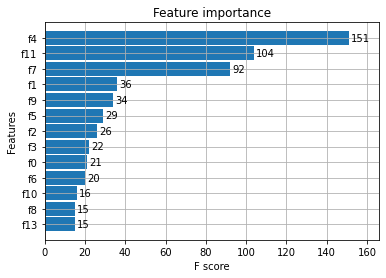

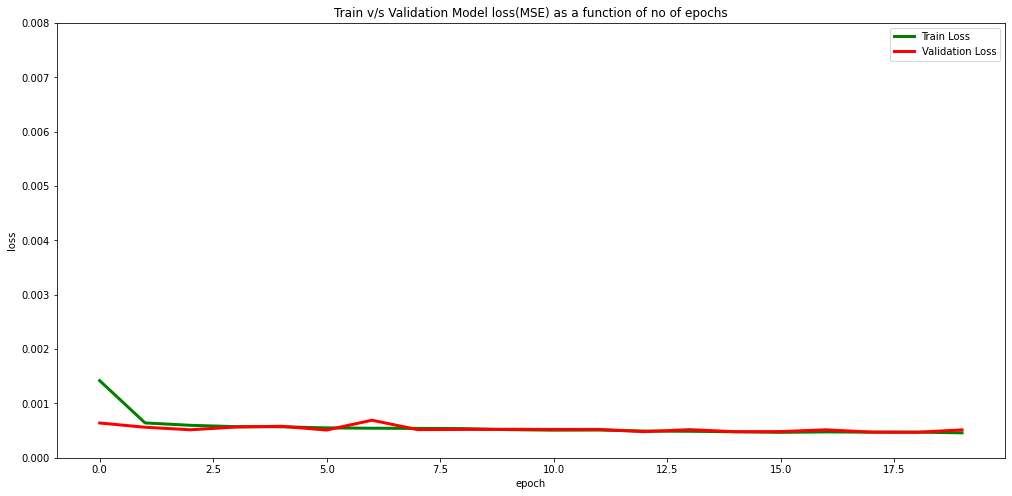

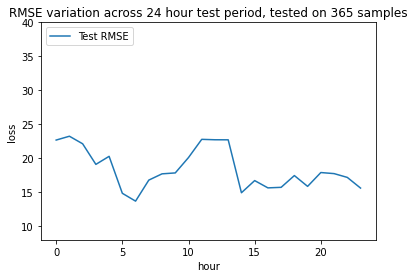

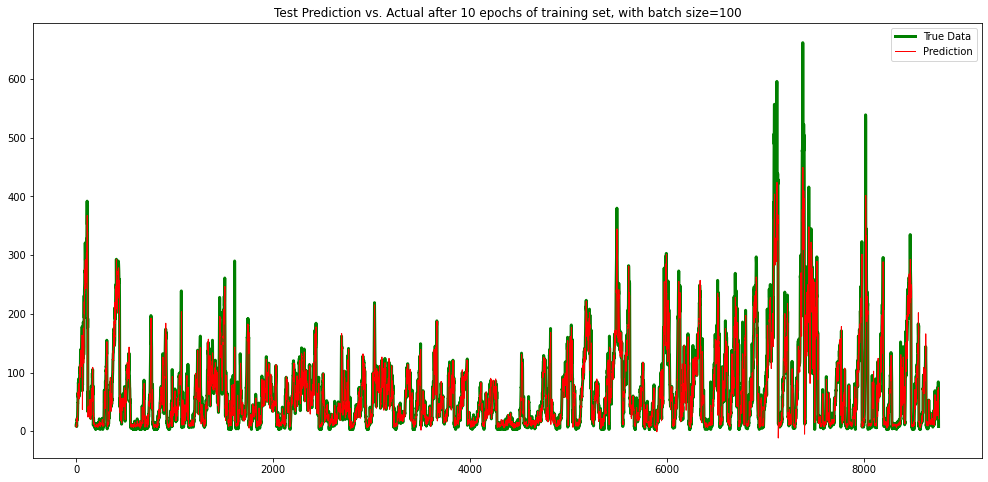

In [0]:
if __name__=='__main__':
  main()